### Install dependencies


In [15]:
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Load files


In [16]:
import pandas as pd

def load_and_process(req_path, test_path):
    req_df = pd.read_csv(req_path, sep=',', on_bad_lines='skip')
    test_df = pd.read_csv(test_path, sep=',', on_bad_lines='skip')
    
    # Some Purpose columns are intentionally left blank for now; populate them with empty strings
    test_df['Purpose'] = test_df['Purpose'].fillna('')

    req_text_fields = ['Feature', 'Description']
    test_text_fields = ['Purpose', 'Test steps']

    # Combine text columns for similarity matching
    req_df['full_text'] = req_df[req_text_fields].astype(str).agg(' '.join, axis=1)
    test_df['full_text'] = test_df[test_text_fields].astype(str).agg(' '.join, axis=1)
    
    # Convert to lists
    req_texts = req_df['full_text'].tolist()
    test_texts = test_df['full_text'].tolist()

    return req_df, test_df, req_texts, test_texts



### Calculate accuracy


In [17]:
def calculate_accuracy(pred_dict, ground_truth_path, test_path, debug=False):
    
    # Load and clean ground truth
    gt_df = pd.read_csv(ground_truth_path).dropna(subset=['Req ID'])
    
    # Convert ground truth data into a dictionary
    gt_dict = {
        row['Req ID']: list(map(str.strip, str(row['Test ID']).split(','))) if pd.notna(row['Test ID']) else []
        for _, row in gt_df.iterrows()
    }
    # pred_dict = dict(pred_dict)

    # correct = 0
    # total = 0

    # # Compare predicted and ground truth
    # for req_id in set(pred_dict.keys()) | set(gt_dict.keys()):
    #     predicted = set(pred_dict.get(req_id, []))
    #     actual = set(gt_dict.get(req_id, []))
    #     total += 1
    #     if predicted == actual:
    #         correct += 1
    # # Calculate accuracy
    # accuracy = (correct / total) * 100 if total > 0 else 0



    ### NEW
    
    # Model stats
    all_n: list[int] = []
    all_tp: list[int] = []
    all_tn: list[int] = []
    all_fp: list[int] = []
    all_fn: list[int] = []

    # Values for confusion matrix
    n: int = 0
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    test_test = pd.read_csv(test_path, sep=',', on_bad_lines='skip')
    test_text_fields = ['ID', 'Purpose', 'Test steps']
    test_test['full_text'] = test_test[test_text_fields].astype(str).agg(' '.join, axis=1)

    curr_tests: set[str]
    curr_tests: set[str] = set(test_test["ID"].astype(str))

    frequency_table: dict[bool, dict[str, dict[str, int]]] = {True: {}, False: {}}


    for req in set(pred_dict.keys()) | set(gt_dict.keys()):
        actual_tests: set[str] = set(gt_dict.get(req, []))
        expected_tests: set[str] = set(pred_dict.get(req, []))
        # Skip if req ID returned None
        if expected_tests is None:
            print(f"Error - {current_dir}: Faulty requirement ID ({req})")
            continue

        # Positives
        curr_tp_set: set[str] = actual_tests & expected_tests
        curr_tp_count: int = len(curr_tp_set)
        if debug:
            print(f"Info - \t\t({curr_tp_count}) {curr_tp_set = }")

        curr_fp_set: set[str] = actual_tests - expected_tests
        curr_fp_count: int = len(curr_fp_set)
        if debug:
            print(f"Info - \t\t({curr_fp_count}) {curr_fp_set = }")
        
        # Negatives
        expected_ns: set[str] = curr_tests - expected_tests
        actual_ns: set[str] = curr_tests - actual_tests

        curr_tn_set: set[str] = actual_ns & expected_ns
        curr_tn_count: int = len(curr_tn_set)
        if debug:
            print(f"Info - \t\t({curr_tn_count}) {curr_tn_set = }")

        curr_fn_set: set[str] = actual_ns - expected_ns
        curr_fn_count: int = len(curr_fn_set)
        if debug:
            print(f"Info - \t\t({curr_fn_count}) {curr_fn_set = }")

        curr_n: int = curr_tp_count + curr_fp_count + curr_tn_count + curr_fn_count
        
        # Check so only the right amount of trace links were detected
        expected_curr_n: int = len(curr_tests)
        if curr_n != expected_curr_n:
            print(f"Error - \t\tExpected curr_n = {expected_curr_n}, got {curr_n = }")
        if debug:
            print(f"Info - \t\t{curr_n = }")

        # Update the frequency table

        # Get the true positives
        true_positives: dict[str, int] = frequency_table[True].get(req, None)
        # Assign a dict if one doesn't exist
        if true_positives is None:
            true_positives = {}
            frequency_table[True][req] = true_positives
        
        # Get the false positives
        false_positives: dict[str, int] = frequency_table[False].get(req, None)
        # Assign a dict if one doesn't exist
        if false_positives is None:
            false_positives = {}
            frequency_table[False][req] = false_positives

        # Add 1 for each true positive link
        for test in curr_tp_set:
            true_positives[test] = true_positives.get(test, 0) + 1

        # Add 1 for each false positive link
        for test in curr_fp_set:
            false_positives[test] = false_positives.get(test, 0) + 1


        n += curr_n
        tp += curr_tp_count
        tn += curr_tn_count
        fp += curr_fp_count
        fn += curr_fn_count

    all_n.append(n)
    all_tp.append(tp)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)

    accuracy: float = (tp + tn) / n if n != 0 else 0.0
    recall: float = tp / (tp + fn) if tp + fn != 0 else 0.0
    precision: float = tp / (tp + fp) if tp + fp != 0 else 0.0
    specificity: float = tn / (tn + fn) if tn + fn != 0 else 0.0
    balanced_accuracy: float = (precision + specificity) / 2
    if debug:
        print("*********************************************")
        print(ground_truth_path)
    # print("Accuracy": f"{accuracy:.2f}%", "Recall": f"{recall:.2f}%", "Precision": f"{precision:.2f}%", "Specificity": f"{specificity:.2f}%", "Balanced Accuracy": f"{balanced_accuracy:.2f}%")

    if debug:
        print("*********************************************")
        print(f"Accuracy: {balanced_accuracy:.2f}%")
        print("*********************************************")
    return accuracy, recall, precision, balanced_accuracy, tp, fp, tn, fn

### Cosine Similarity


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def custom_preprocessor(text):
    text = text.lower()
    text = re.sub(r'[^A-Za-z\s]', '', text)
    return text

def custom_tokenizer(text):
    return [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

def compute_cosine(req_df, test_df, req_texts, test_texts, true_matches, test_path, param):

    vectorizer = TfidfVectorizer(
        preprocessor=custom_preprocessor,
        tokenizer=custom_tokenizer,
        token_pattern=None
    )

    documents = req_texts + test_texts
    tfidf_matrix = vectorizer.fit_transform(documents)

    similarity_matrix = cosine_similarity(tfidf_matrix[:len(req_texts)], tfidf_matrix[len(req_texts):])
    
    best_threshold, best_param, best_matches = 0, 0, {}

    # Define a range of thresholds to test
    thresholds = np.linspace(0.1, 1.0, 91) # 0.1, 0.2, 0.3, ... 1.0

    # Initialize storage for metrics
    threshold_values = []
    accuracy_values = []
    recall_values = []
    precision_values = []
    balanced_accuracy_values = []

    # Iterate through different thresholds
    for threshold in thresholds:
        matches = {}
        for i, req_id in enumerate(req_df['ID']):
            matched_test_ids = []
            for j, similarity in enumerate(similarity_matrix[i]):
                if similarity >= threshold:
                    matched_test_ids.append(str(test_df.iloc[j]['ID']))
            matches[str(req_id)] = matched_test_ids

        accuracy, recall, precision, balanced_accuracy, _, _, _, _ = calculate_accuracy(matches, true_matches, test_path)

        threshold_values.append(threshold)
        accuracy_values.append(accuracy)
        recall_values.append(recall)
        precision_values.append(precision)
        balanced_accuracy_values.append(balanced_accuracy)

        metric_dict = {
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "balanced_accuracy": balanced_accuracy
        }
        
        # Update the best threshold
        if metric_dict[param] > best_param:
            best_threshold, best_param, best_matches = threshold, accuracy, matches

    print(f"Param:" f"{param}")
    print(f"Best Threshold: {best_threshold}")
    print(f"Best Param: {best_param}")

    return best_matches, best_threshold, threshold_values, accuracy_values, recall_values, precision_values, balanced_accuracy_values


### Display predicted and Ground Truth results side by side


In [19]:
def print_side_by_side(pred_dict, mapping_path):
    
    # Ground Truth Dataset
    gt_df = pd.read_csv(mapping_path)

    # Convert to dict
    gt_dict = {
        row['Req ID']: list(map(str.strip, str(row['Test ID']).split(','))) if pd.notna(row['Test ID']) else []
        for _, row in gt_df.iterrows()
    }
    
    # Get the union of all requirement IDs
    all_req_ids = sorted(set(pred_dict.keys()) | set(gt_dict.keys()))

    print(f"\n{'Req ID':<10} | {'Predicted':<20} | {'Ground Truth'}")
    print("-" * 55)

    for req_id in all_req_ids:
        pred_ids = ', '.join(map(str, pred_dict.get(req_id, [])))
        gt_ids = ', '.join(gt_dict.get(req_id, []))
        print(f"{req_id:<10} | {pred_ids:<20} | {gt_ids}")


Dataset: AMINA
*********************************************
OPTIMIZING FOR: accuracy
*********************************************
Param:accuracy
Best Threshold: 0.49
Best Param: 0.9969230769230769
*********************************************
OPTIMIZING FOR: recall
*********************************************


/var/folders/q8/fj2nlt_d3vqd2yr3m8kvphq80000gn/T/ipykernel_25516/4163057028.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_table = pd.concat([


Param:recall
Best Threshold: 1.0
Best Param: 0.9899230769230769
*********************************************
OPTIMIZING FOR: precision
*********************************************
Param:precision
Best Threshold: 0.15000000000000002
Best Param: 0.9724615384615385
*********************************************
OPTIMIZING FOR: balanced_accuracy
*********************************************
Param:balanced_accuracy
Best Threshold: 0.16
Best Param: 0.9767692307692307


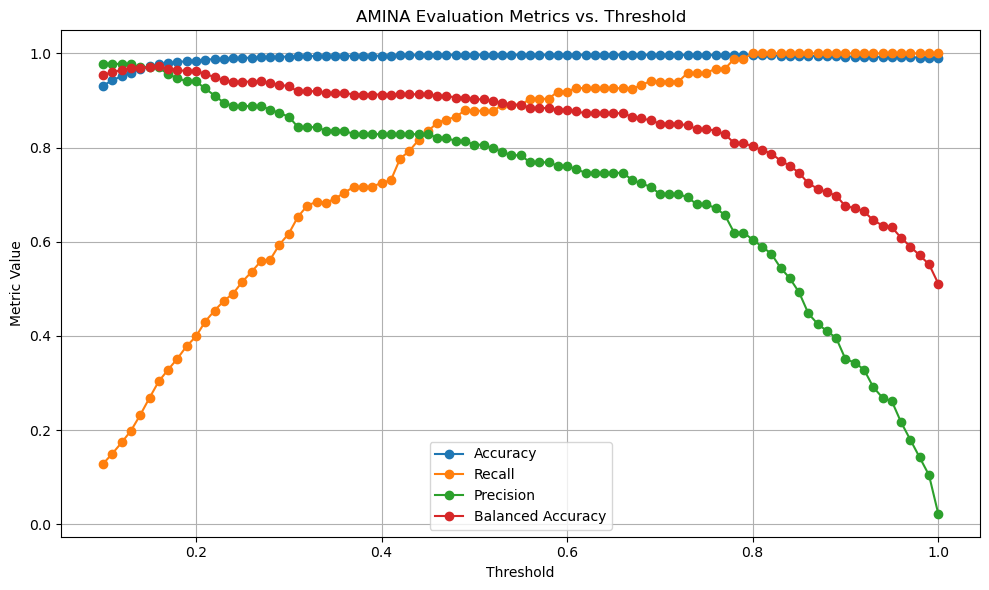

Dataset: BTHS
*********************************************
OPTIMIZING FOR: accuracy
*********************************************
Param:accuracy
Best Threshold: 0.44000000000000006
Best Param: 0.8583333333333333
*********************************************
OPTIMIZING FOR: recall
*********************************************
Param:recall
Best Threshold: 0.44000000000000006
Best Param: 0.8583333333333333
*********************************************
OPTIMIZING FOR: precision
*********************************************
Param:precision
Best Threshold: 0.26
Best Param: 0.65
*********************************************
OPTIMIZING FOR: balanced_accuracy
*********************************************
Param:balanced_accuracy
Best Threshold: 0.31
Best Param: 0.7416666666666667


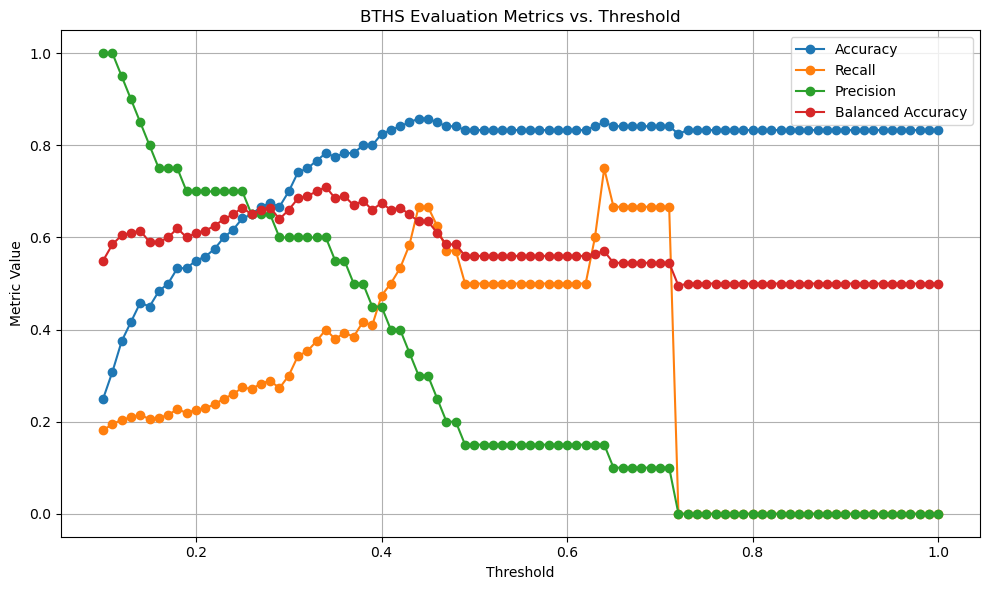

Dataset: Mozilla
*********************************************
OPTIMIZING FOR: accuracy
*********************************************
Param:accuracy
Best Threshold: 0.75
Best Param: 0.9970597029801654
*********************************************
OPTIMIZING FOR: recall
*********************************************
Param:recall
Best Threshold: 0.88
Best Param: 0.9968479019236519
*********************************************
OPTIMIZING FOR: precision
*********************************************
Param:precision
Best Threshold: 0.11
Best Param: 0.9375062294428387
*********************************************
OPTIMIZING FOR: balanced_accuracy
*********************************************
Param:balanced_accuracy
Best Threshold: 0.13
Best Param: 0.9490805342370179


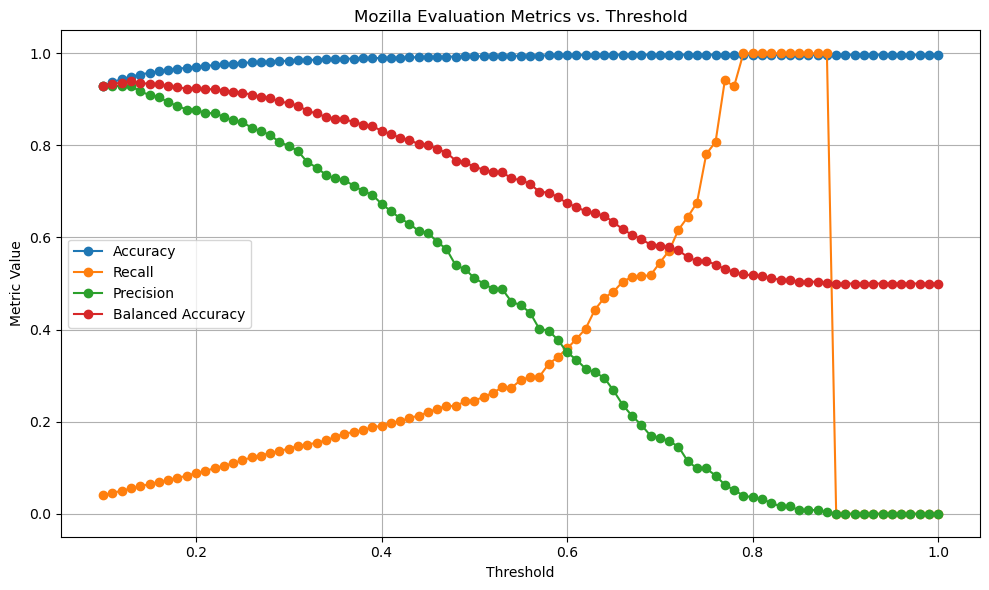

Dataset: HealthWatcher
*********************************************
OPTIMIZING FOR: accuracy
*********************************************
Param:accuracy
Best Threshold: 0.45000000000000007
Best Param: 0.9382716049382716
*********************************************
OPTIMIZING FOR: recall
*********************************************
Param:recall
Best Threshold: 0.76
Best Param: 0.9012345679012346
*********************************************
OPTIMIZING FOR: precision
*********************************************
Param:precision
Best Threshold: 0.24000000000000002
Best Param: 0.8518518518518519
*********************************************
OPTIMIZING FOR: balanced_accuracy
*********************************************
Param:balanced_accuracy
Best Threshold: 0.24000000000000002
Best Param: 0.8518518518518519


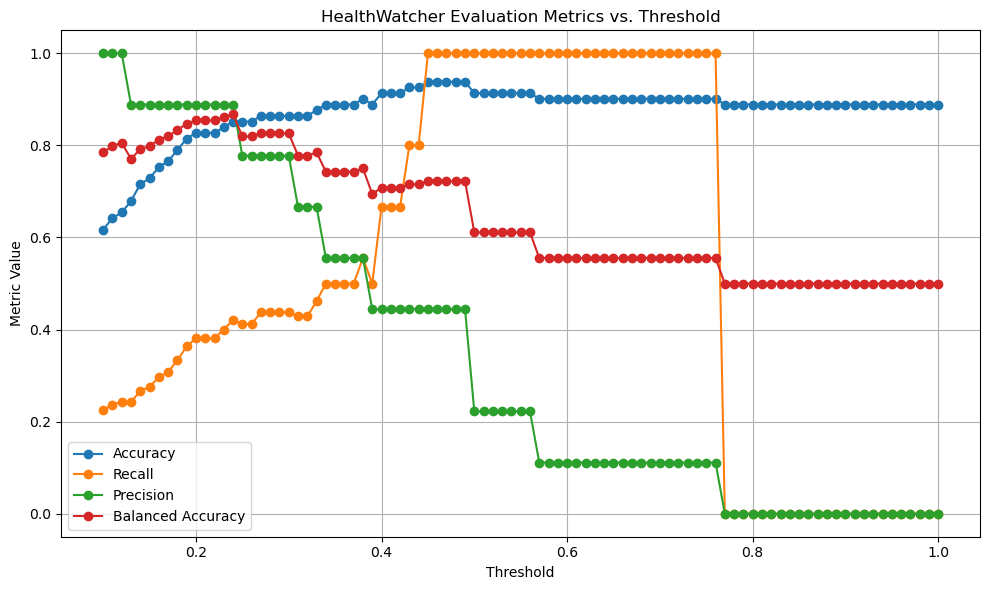



+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+
| Optimizing for:      | Dataset          | Threshold      | TP       |FP       | TN       |FN       |Accuracy    | Recall | Precision| Balanced Accuracy |
+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+
| accuracy             | AMINA            | 0.49           | 109      | 25      | 12851    | 15      | 1.00       | 0.88   | 0.81     | 0.906133          |
| accuracy             | BTHS             | 0.44           | 6        | 14      | 97       | 3       | 0.86       | 0.67   | 0.30     | 0.635000          |
| accuracy             | Mozilla          | 0.75           | 25       | 229     | 80003    | 7       | 1.00       | 0.78   | 0.10     | 0.549169          |
| accuracy             | HealthWatcher    | 0.45           | 4

In [20]:
import json 
import os
import time

# Datasets folders 
datasets = ["AMINA", "BTHS", "Mozilla", "HealthWatcher"] 
# 'BTHS', 'Mozilla', 'HealthWatcher'
#Initialize summary table for visualization of results
summary_table = pd.DataFrame(columns=["Dataset", "Accuracy"])

# For every dataset find the following:
for dataset in datasets:
    
    req_path = f'../data/{dataset}/RE.csv'
    test_path = f'../data/{dataset}/ST.csv'
    ground_truth_mapping_path = f'../data/{dataset}/mapping.csv'

    print(f"Dataset: {dataset}")
    
    # Load and process data
    req_df, test_df, req_texts, test_texts = load_and_process(req_path, test_path)
    
    # Find cosine similarity and measure execution time
    start = time.time()

    metric_dict = [
        "accuracy",
        "recall",
        "precision",
        "balanced_accuracy"
    ]

    for param in metric_dict:
        print("*********************************************")
        print(f"OPTIMIZING FOR: {param}")
        print("*********************************************")
        predicted, threshold, threshold_values, accuracy_values, recall_values, precision_values, balanced_accuracy_values = compute_cosine(req_df, test_df, req_texts, test_texts, ground_truth_mapping_path, test_path, param)
        t = time.time() - start
        
        # ***************************************************
        # Analyzing results (accuracy + visual comparison)
        # ***************************************************

        # Print results side by side 
        # print_side_by_side(predicted, ground_truth_mapping_path)
        # Compute accuracy
        accuracy, recall, precision, balanced_accuracy, true_positives, false_positives, true_negatives, false_negatives = calculate_accuracy(predicted, ground_truth_mapping_path, test_path, debug=False)

        summary_table = pd.concat([
            summary_table,
            pd.DataFrame([{"Param": param, "Dataset": dataset, "Threshold": f"{threshold:.2f}", "TP": true_positives, "FP": false_positives, "TN": true_negatives, "FN": false_negatives, "Accuracy": accuracy, "Recall": recall, "Precision": precision, "Balanced Accuracy": balanced_accuracy}])
        ], ignore_index=True)


    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(threshold_values, accuracy_values, label='Accuracy', marker='o')
    plt.plot(threshold_values, recall_values, label='Recall', marker='o')
    plt.plot(threshold_values, precision_values, label='Precision', marker='o')
    plt.plot(threshold_values, balanced_accuracy_values, label='Balanced Accuracy', marker='o')

    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title(f'{dataset} Evaluation Metrics vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Payload is formatted exactly as at REST-AT and saved to the corresponding data folder
    # Cosine similarity result is deterministic, so there's no need for multiple executions
    payload: dict[str, dict] = {
        "meta": {
            "req_path": req_path,
            "test_path": test_path,
            "mapping_path": ground_truth_mapping_path
        },
        "data": {
            "links": predicted,
            "time-to-analyze": t
        }
    }
    log_dir: str = f"./{dataset}"
    os.makedirs(log_dir, exist_ok=True)

    with open(f"{log_dir}/res.json", "w+") as out:
        json.dump(payload, out, indent=2)


print("\n")

# Print Final Results Table
print("+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+")
print("| Optimizing for:      | Dataset          | Threshold      | TP       |FP       | TN       |FN       |Accuracy    | Recall | Precision| Balanced Accuracy |")
print("+----------------------+------------------+----------------+----------+---------+----------+---------+------------+--------+----------+-------------------+")

summary_table = summary_table.sort_values(by='Param')

for _, row in summary_table.iterrows():
    print(f"| {row['Param']:<20} "
        f"| {row['Dataset']:<16} "
        f"| {row['Threshold']:<14} "
        f"| {int(row['TP']):<8} "
        f"| {int(row['FP']):<7} "
        f"| {int(row['TN']):<8} "
        f"| {int(row['FN']):<7} "
        f"| {row['Accuracy']:<10.2f} "
        f"| {row['Recall']:<6.2f} "
        f"| {row['Precision']:<8.2f} "
        f"| {row['Balanced Accuracy']:<18f}|")
("+----------------------+------------------+----------------+----------+---------+------------+--------+----------+-------------------+")

summary_table.to_csv("summary_table.csv", index=False)


# Initial version of the table
# Print Final Results Table
# print("+------------------+---------------+")
# print("| Dataset          | Accuracy (%)  |")
# print("+------------------+---------------+")
# for _, row in summary_table.iterrows():
#     accuracy_str = f"{row['Accuracy']:.2f}%"
#     print(f"| {row['Dataset']:<16} | {accuracy_str:<13.7} |") 
# print("+------------------+---------------+")



